In [3]:
import torch
import pytorch_lightning as pytorch_lightning
import sys

sys.path.append('./lhdm')
sys.path.append('./lhdm/data')

from irn_dataset import DataHandler
%load_ext autoreload
%autoreload 2

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hparams = {
    "split_ratio": [80, 10, 10],
    "device": device,
    "batch_size": 8,
    "num_workers": 4,
    "sample_limit": 1,
    "input_dim": 1185,
    "output_dim": 1185,
    "hidden_dim": 512,
    "z_dim": 64
}
datahandler = DataHandler(hparams, "lhdm/data/mnist-inrs", "cifar10_png_train_airplane_")

train_loader = datahandler.train_dataloader()
val_loader = datahandler.val_dataloader()
next(iter(train_loader))

odict_keys(['seq.0.weight', 'seq.0.bias', 'seq.1.weight', 'seq.1.bias', 'seq.2.weight', 'seq.2.bias'])


tensor([[ 0.0446,  0.0049, -0.0271,  ...,  0.1080, -0.1606, -0.1671]])

In [ ]:
import sys
sys.path.append('./lhdm/models')

from mlp_models import MLP
from inr import INR
state_dict = datahandler.get_state_dict(index=0)

params = {
    "input_size": 2,
    "hidden_size": 32,
    "output_size": 1
}

#mlp = MLP(params)
mlp = INR()
print(mlp)
mlp.load_state_dict(state_dict)
test_input = torch.randn(2)
print(test_input)
print(mlp(test_input))


NameError: name 'datahandler' is not defined

[[-1.         -1.        ]
 [-0.92592593 -1.        ]
 [-0.85185185 -1.        ]
 ...
 [ 0.85185185  1.        ]
 [ 0.92592593  1.        ]
 [ 1.          1.        ]]


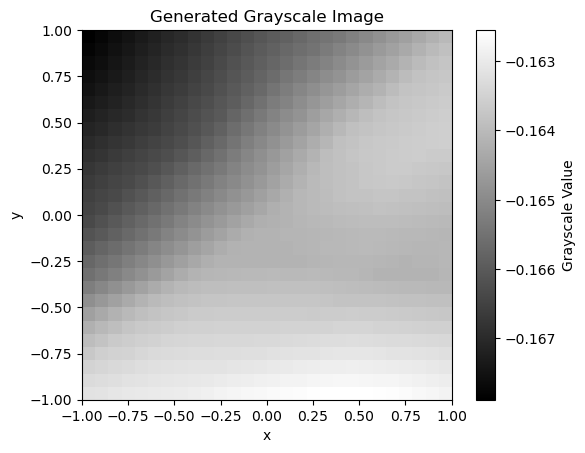

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a 28x28 grid of (x, y) inputs
resolution = 28
x = np.linspace(-1, 1, resolution)  # Normalize to range [-1, 1]
y = np.linspace(-1, 1, resolution)
grid_x, grid_y = np.meshgrid(x, y)

# Flatten the grid into a list of (x, y) pairs
inputs = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)
print(inputs)
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)

# Pass the inputs through the MLP
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = mlp(inputs_tensor).numpy()

# Reshape the outputs into a 28x28 image
image = outputs.reshape(resolution, resolution)

# Plot the image
plt.imshow(image, cmap="gray", extent=(-1, 1, -1, 1))
plt.colorbar(label="Grayscale Value")
plt.title("Generated Grayscale Image")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [8]:
import pytorch_lightning as pl
import torch
from pytorch_lightning.loggers import WandbLogger
from models import Autoencoder

wandb_logger = WandbLogger(log_model="all")
trainer = pl.Trainer(logger=wandb_logger, max_epochs=10)

model = Autoencoder(ddconfig=hparams, embed_dim=16)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: simon-blessmann (simon-blessmann-technical-university-of-munich). Use `wandb login --relogin` to force relogin



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 640 K  | train
1 | decoder | Decoder | 641 K  | train
--------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.125     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/simon/anaconda3/envs/lhdm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/home/simon/anaconda3/envs/lhdm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/home/simon/anaconda3/envs/lhdm/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 1/1 [00:09<00:00,  0.11it/s, v_num=a18w, aeloss_step=0.000151, aeloss_epoch=0.000151]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:09<00:00,  0.10it/s, v_num=a18w, aeloss_step=0.000151, aeloss_epoch=0.000151]
